## Import necessary packages:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from plotter import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

seed = 0

Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']

DoS = ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']

R2L = ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']

U2R = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess',
       'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']

## Import data and assign feature name to each column:

In [2]:
columns = []
with open('kddcup.names') as f:
    next(f)
    for line in f:
        feature = line.split(':')[0]
        columns.append(feature)
columns.append('label')

In [3]:
train_data = pd.read_csv('kddcup.data', header=None)
train_data.columns = columns
train_data['label'] = train_data['label'].apply(lambda x: x.replace('.', ''))

test_data = pd.read_csv('corrected', header=None)
test_data.columns = columns
test_data['label'] = test_data['label'].apply(lambda x: x.replace('.', ''))

In [4]:
boundary = train_data.shape[0]
whole_data = pd.concat([train_data, test_data], axis=0)

## One-hot encoding:

In [5]:
categorical = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
whole_data_categorical = whole_data[categorical].copy()
whole_data.drop(columns=categorical, inplace=True)
whole_data_categorical_T = pd.get_dummies(whole_data_categorical)
whole_data = pd.concat([whole_data_categorical_T, whole_data], axis=1)

## Split data into training and test set:

In [6]:
train_data = whole_data.iloc[:boundary]
test_data = whole_data.iloc[boundary:]

X_train, y_train = train_data.drop(columns='label'), train_data['label']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=seed)
X_test, y_test = test_data.drop(columns='label'), test_data['label']

## Convert specific attack types to four general attack types in y_valid and y_test:

In [7]:
for attack in Probe:
    y_valid = y_valid.replace(attack, 'Probe')
    y_test = y_test.replace(attack, 'Probe')
    
for attack in DoS:
    y_valid = y_valid.replace(attack, 'DoS')
    y_test = y_test.replace(attack, 'DoS')
    
for attack in R2L:
    y_valid = y_valid.replace(attack, 'R2L')
    y_test = y_test.replace(attack, 'R2L')
    
for attack in U2R:
    y_valid = y_valid.replace(attack, 'U2R')
    y_test = y_test.replace(attack, 'U2R')

## Store preprocessed data for later usage:

In [8]:
X_train.to_pickle("X_train.pkl")
y_train.to_pickle("y_train.pkl")

X_valid.to_pickle("X_valid.pkl")
y_valid.to_pickle("y_valid.pkl")

X_test.to_pickle("X_test.pkl")
y_test.to_pickle("y_test.pkl")

## Load preprocessed data back:

In [2]:
X_train = pd.read_pickle("X_train.pkl")
y_train = pd.read_pickle("y_train.pkl")

X_valid = pd.read_pickle("X_valid.pkl")
y_valid = pd.read_pickle("y_valid.pkl")

X_test = pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle("y_test.pkl")

## Sample a subset of training data from the original training set:

In [3]:
# Recombine X_train and y_train into a dataframe:
X_train_df = pd.concat([X_train, y_train], axis=1)

In [4]:
# Divide instances by label:
label_list = np.unique(X_train_df['label'])

df_label_list = []
for label in label_list:
    df_label_list.append(X_train_df[X_train_df['label'] == label])

In [5]:
# Determine how many instances are sampled from each label:
num_samples_per_label = 100
X_train_df_sampled = pd.DataFrame()

for df in df_label_list:
    num_instances = df.shape[0]
    
    replace = False
    if num_instances < num_samples_per_label:
        replace = True
    
    df_sampled = df.sample(n=num_samples_per_label, replace=replace, random_state=seed)
    X_train_df_sampled = pd.concat([X_train_df_sampled, df_sampled], axis=0)

In [6]:
# Decompose X_train_df_sampled into X_train and y_train again:
X_train, y_train = X_train_df_sampled.drop(columns='label'), X_train_df_sampled['label']

## Convert specific attack types to four general attack types in y_train:

In [7]:
for attack in Probe:
    y_train = y_train.replace(attack, 'Probe')
    
for attack in DoS:
    y_train = y_train.replace(attack, 'DoS')
    
for attack in R2L:
    y_train = y_train.replace(attack, 'R2L')
    
for attack in U2R:
    y_train = y_train.replace(attack, 'U2R')

## Standardize feature vectors using StandardScaler:

In [8]:
sscaler = preprocessing.StandardScaler().fit(X_train)
X_train, X_valid, X_test = sscaler.transform(X_train), sscaler.transform(X_valid), sscaler.transform(X_test)

/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## Stratified holdout validation:

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

## Softmax Regression for multinomial classification:
### Linear decision boundary:
Combine L1 regularization for **embedded** feature selection. <br/>
Can also serve as a feature selection **wrapper** for the subsequent SVM.

In [10]:
parameters = {
    #'C': np.logspace(-5, 5, 30)
    'C': [1]
}

# L1 regularization mimics the feature selection process due to its sparsity.
gs_lgr = GridSearchCV(LogisticRegression(multi_class='multinomial', penalty='l1', class_weight='balanced', solver='saga'), parameters, cv=sss)
gs_lgr.fit(X_train[:10000], y_train[:10000])

lgr = gs_lgr.best_estimator_
y_pred_valid = lgr.predict_proba(X_valid)

# Multiclass average ROC_AUC score:
avg_roc_auc = 0
for i, label in enumerate(lgr.classes_):
    y_valid_label = (y_valid == label).astype(int)
    y_pred_valid_label = y_pred_valid[:,i]
    avg_roc_auc += roc_auc_score(y_valid_label, y_pred_valid_label)
    
avg_roc_auc /= len(lgr.classes_)

print ("The best average ROC_AUC for Logistic Regression on validation set is {:.4f}".format(avg_roc_auc))
display(gs_lgr.best_params_)

/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/dme/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The best average ROC_AUC for Logistic Regression on validation set is 0.9971


{'C': 1}

## Plot confusion matrix of the Softmax Regression on validation set:

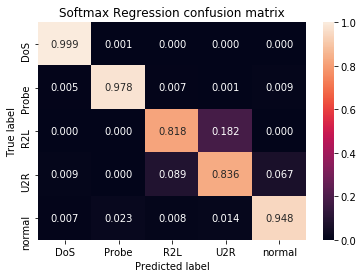

In [11]:
y_pred_valid = lgr.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, classes=lgr.classes_, title='Softmax Regression confusion matrix')

## Perform feature selection through the weights of previous Logistic Regression model:

In [12]:
weights_across_classes = np.sum(lgr.coef_, axis=0)
idx_selected_features = np.nonzero(weights_across_classes)[0]
selected_features = X_train_df.columns[idx_selected_features]
display(selected_features)

X_train, X_valid, X_test = X_train[:, idx_selected_features], X_valid[:, idx_selected_features], X_test[:, idx_selected_features]

Index(['land', 'logged_in', 'is_guest_login', 'protocol_type_icmp',
       'protocol_type_tcp', 'protocol_type_udp', 'service_daytime',
       'service_domain_u', 'service_eco_i', 'service_ecr_i', 'service_finger',
       'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4',
       'service_kshell', 'service_ldap', 'service_login', 'service_mtp',
       'service_netstat', 'service_nntp', 'service_other', 'service_pop_3',
       'service_private', 'service_smtp', 'service_telnet', 'service_tim_i',
       'service_whois', 'flag_REJ', 'flag_RSTO', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S3', 'flag_SF', 'flag_SH', 'duration', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_s

## SVM with radial basis function (rbf) kernel for OvR multiclass classification:
### Non-linear decision boundary:

In [ ]:
parameters = {
    'C': np.logspace(-5, 5, 10),
    'gamma': np.logspace(-5, 0, 5)
}

gs_svm_rbf = GridSearchCV(SVC(kernel='rbf', decision_function_shape='ovr', class_weight='balanced'), parameters, cv=sss)
gs_svm_rbf.fit(X_train, y_train)

svm_rbf = gs_svm_rbf.best_estimator_
y_pred_valid = svm_rbf.decision_function(X_valid)

# Multiclass average ROC_AUC score:
avg_roc_auc = 0
for i, label in enumerate(svm_rbf.classes_):
    y_valid_label = (y_valid == label).astype(int)
    y_pred_valid_label = y_pred_valid[:,i]
    avg_roc_auc += roc_auc_score(y_valid_label, y_pred_valid_label)
    
avg_roc_auc /= len(svm_rbf.classes_)

print ("The best average ROC_AUC for Support Vector Machine with rbf kernel on validation set is {:.4f}".format(avg_roc_auc))
display(gs_svm_rbf.best_params_)

## Plot confusion matrix of the SVM on validation set:

In [ ]:
y_pred_valid = svm_rbf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, classes=svm_rbf.classes_, title='SVM with rbf kernel confusion matrix')